# Dataset Creation

## Introduction
Before training models, the current images of the dataset are converted into a plausible format for the algorithms further used: ResNet, Yolov8, and PaDiM. This involves a train, test, validate split.

This notebook also solves two issues with the dataset:
1. **High resolution images**: Slicing Aided Hyperinference (SAHI) is used to deliver lower resolution images.
2. **Imbalanced dataset**: Methodologies are implemented to ensure each class is well represented in each split.

This notebook uses the "Decospan fineerplaten dataset" which is annotated in the "LabelMe JSON Annotation Format" with LabelMe.


## Imports

In [1]:
import labelme2coco
import json
import random
import os
import shutil
from sahi.slicing import slice_coco
from torch import nn
import torch
import matplotlib.pyplot as plt
import numpy as np 
from sahi.utils.coco import Coco
import cv2
from tqdm import tqdm
from PIL import Image

## Configurable variables

In [2]:
# Naming variables
classes = ('bg', 'faults')
train = "train"
validate = "validate"
test = "test"

# Split settings
test_percentage = 14
validate_percentage = 14

# Input directory
labelme_annotation_directory = "labelme_annotations"
image_input_extension = ".jpg"

# Intermediate output folders
coco_annotation_directory = "full_dataset_coco"
coco_full_split_directory = "coco_full_split"
coco_window_split_directory = "coco_window_split"
sahi_output = "sahi_output"

# Output folders & variables
binary_window_directory = "binary_window"
fault_only = "fault_only"
sampled_bg_fault = "sampled_bg_fault"
full_bg_fault = "full_bg_fault"
yolo_dataset = "yolo_dataset"

#Sahi settings
window_size = 480
overlap_percentage = 20

## Conversion to COCO format
LabelMe uses the "LabelMe JSON Annotation Format", this is converted to the more widely used COCO format.

In [3]:
# Convert labelme images to COCO format
labelme2coco.convert(labelme_annotation_directory, coco_annotation_directory)

# Stats
coco = Coco.from_coco_dict_or_path(coco_annotation_directory+"/dataset.json")
print(coco.stats)

There are 367 listed files in folder labelme_annotations.


Converting labelme annotations to COCO format: 100%|██████████| 367/367 [00:00<00:00, 1994.59it/s]
05/23/2024 16:49:16 - INFO - labelme2coco -   Converted annotations in COCO format is exported to full_dataset_coco\dataset.json


indexing coco dataset annotations...


Loading coco annotations: 100%|██████████| 367/367 [00:00<00:00, 4170.50it/s]

{'num_images': 367, 'num_annotations': 935, 'num_categories': 11, 'num_negative_images': 0, 'num_images_per_category': {'open fout': 124, 'open voeg': 57, 'deuk': 73, 'zaag': 102, 'barst': 16, 'open knop': 18, 'snijfout': 7, 'veneer piece': 28, 'vlek': 35, 'ongekend': 2, 'kras': 18}, 'num_annotations_per_category': {'open fout': 217, 'open voeg': 119, 'deuk': 85, 'zaag': 154, 'barst': 22, 'open knop': 137, 'snijfout': 24, 'veneer piece': 32, 'vlek': 94, 'ongekend': 3, 'kras': 48}, 'min_num_annotations_in_image': 1, 'max_num_annotations_in_image': 26, 'avg_num_annotations_in_image': 2.5476839237057223, 'min_annotation_area': 129, 'max_annotation_area': 2943700, 'avg_annotation_area': 110788.59786096256, 'min_annotation_area_per_category': {'open fout': 407, 'open voeg': 1882, 'deuk': 1463, 'zaag': 1785, 'barst': 6894, 'open knop': 129, 'snijfout': 5029, 'veneer piece': 902, 'vlek': 1340, 'ongekend': 11532, 'kras': 1159}, 'max_annotation_area_per_category': {'open fout': 2943700, 'open v

## Train-Test-Validation Split
In this section, we split the dataset into training, validation, and test sets. The partitioning is done based on the full-scale images, ensuring that SAHI windows originating from the same source image remain together within each of the three categories. This approach maintains the integrity of the source images across the splits.

Furthermore, checks are implemented to ensure that each fault category is adequately represented in each split. This balanced representation is crucial for training robust and generalizable models.

In [4]:
# Split images into train - test - validate (in memory dictionary)
f = open(coco_annotation_directory+'/dataset.json') # get json cocofile
coco_data = json.load(f)

# Calculate the number of images for each split
total_images = len(coco_data['images'])
num_validate = int(total_images * validate_percentage / 100)
num_test = int(total_images * test_percentage / 100)
num_train = total_images - num_validate - num_test

# Shuffle the images randomly
random.seed(20) # Change this (trial/error) to get optimal results
random.shuffle(coco_data['images'])

# Dictionary that holds split information
split_dict = {}
split_dict_id = {}

for i, image_info in enumerate(coco_data['images']):
    if i < num_validate:
        split_dict[image_info['file_name']] = validate
        split_dict_id[image_info['id']] = validate
    elif i < num_validate + num_test:
        split_dict[image_info['file_name']] = test
        split_dict_id[image_info['id']] = test
    else:
        split_dict[image_info['file_name']] = train
        split_dict_id[image_info['id']] = train

To check if the specific faults types are equally distributed between train-test-validation, 2 plots are created

{0: 'open fout', 1: 'open voeg', 2: 'deuk', 3: 'zaag', 4: 'barst', 5: 'open knop', 6: 'snijfout', 7: 'veneer piece', 8: 'vlek', 9: 'ongekend', 10: 'kras'}
{'open fout': {'train': 177, 'test': 18, 'validate': 22}, 'open voeg': {'train': 72, 'test': 10, 'validate': 37}, 'deuk': {'train': 58, 'test': 15, 'validate': 12}, 'zaag': {'train': 124, 'test': 13, 'validate': 17}, 'barst': {'train': 18, 'test': 3, 'validate': 1}, 'open knop': {'train': 90, 'test': 34, 'validate': 13}, 'snijfout': {'train': 13, 'test': 8, 'validate': 3}, 'veneer piece': {'train': 21, 'test': 8, 'validate': 3}, 'vlek': {'train': 76, 'test': 7, 'validate': 11}, 'ongekend': {'train': 1, 'test': 0, 'validate': 2}, 'kras': {'train': 32, 'test': 4, 'validate': 12}}


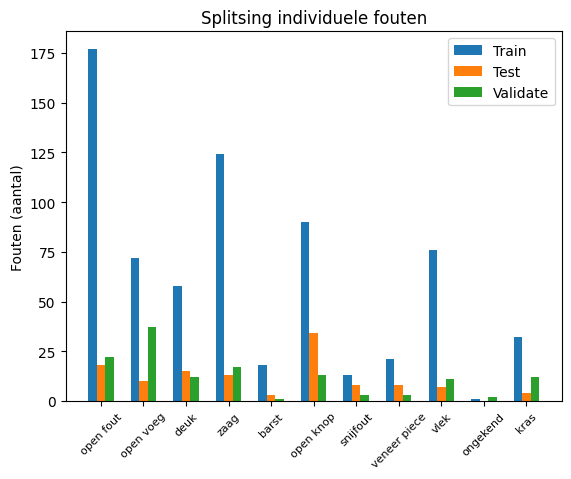

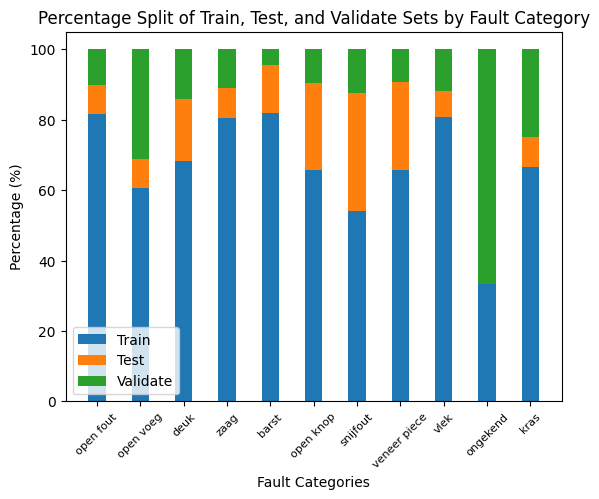

In [5]:
# Faults count dictionary
fault_count_dict = {}

# Get categories
cat_dict = {}
for i, cat_info in enumerate(coco_data['categories']):
    cat_dict[cat_info['id']] = cat_info['name']
    fault_count_dict[cat_info['name']] = {'train': 0, 'test': 0, 'validate': 0}

print(cat_dict)

# Get faults
for i, ann_info in enumerate(coco_data['annotations']):
    name = cat_dict[ann_info["category_id"]]
    split = split_dict_id[ann_info['image_id']]
    fault_count_dict[name][split] += 1 

print(fault_count_dict)    

# Place data in right structure for plot
faults = list(fault_count_dict.keys())
num_train = [fault_count_dict[fault]['train'] for fault in faults]
num_test = [fault_count_dict[fault]['test'] for fault in faults]
num_validate = [fault_count_dict[fault]['validate'] for fault in faults]

# Set up the plot
X_axis = np.arange(len(faults))

plt.bar(X_axis - 0.2, num_train, 0.2, label='Train')
plt.bar(X_axis, num_test, 0.2, label='Test')
plt.bar(X_axis + 0.2, num_validate, 0.2, label='Validate')

plt.xticks(X_axis, faults, rotation=45, fontsize=8)
plt.xlabel("")
plt.ylabel("Faults (count)")
plt.title("Distribution of Individual Faults")
plt.legend()
plt.show()

# Calculate totals and percentages
faults = list(fault_count_dict.keys())
totals = [sum(fault_count_dict[fault].values()) for fault in faults]
num_train_pct = [fault_count_dict[fault]['train'] / total * 100 for fault, total in zip(faults, totals)]
num_test_pct = [fault_count_dict[fault]['test'] / total * 100 for fault, total in zip(faults, totals)]
num_validate_pct = [fault_count_dict[fault]['validate'] / total * 100 for fault, total in zip(faults, totals)]

# Set up the plot
X_axis = np.arange(len(faults))

# Create stacked bars
plt.bar(X_axis, num_train_pct, 0.4, label='Train')
plt.bar(X_axis, num_test_pct, 0.4, bottom=num_train_pct, label='Test')
plt.bar(X_axis, num_validate_pct, 0.4, bottom=np.array(num_train_pct) + np.array(num_test_pct), label='Validate')

plt.xticks(X_axis, faults, rotation=45, fontsize=8)
plt.xlabel("Fault Categories")
plt.ylabel("Percentage (%)")
plt.title("Percentage Split of Train, Test, and Validate Sets by Fault Category")
plt.legend()
plt.show()

## **SAHI**
The high resolution images are split into multiple windows using the sliding window method. SAHI operates by dividing each high-resolution image into multiple smaller windows. This process, known as the sliding window technique, involves moving a fixed-size window across the image in steps, capturing different parts of the image in each move. This technique allows for detailed analysis of the entire image without compromising the resolution quality by resizing. It ensures that small details are captured and analyzed, which is crucial for accurate image detection and classification tasks.


In [7]:
for i in [train, validate, test]:
    os.makedirs(sahi_output+"/"+i, exist_ok=True)
    coco_dict, coco_path = slice_coco(
    coco_annotation_file_path=coco_full_split_directory+"/"+i+".json",
    image_dir=labelme_annotation_directory,
    ignore_negative_samples=False,
    output_coco_annotation_file_name="sahi",
    output_dir=sahi_output+"/"+i,
    slice_height=window_size,
    slice_width=window_size,
    overlap_height_ratio=overlap_percentage / 100,
    overlap_width_ratio=overlap_percentage / 100,
    min_area_ratio=0.04,
    verbose=False
    )

indexing coco dataset annotations...


100%|██████████| 264/264 [10:46<00:00,  2.45s/it]


indexing coco dataset annotations...


100%|██████████| 51/51 [02:05<00:00,  2.47s/it]


indexing coco dataset annotations...


100%|██████████| 51/51 [02:06<00:00,  2.48s/it]


## **Final dataset generation**

To support different machine learning models, the final dataset is being prepared in multiple file formats. This ensures compatibility and optimization for diverse algorithmic requirements. The formats include:

- **COCO Format**: Standard for object detection models.
- **Binary Window Format**: Organizes images into binary categories within folders, typically used for simplified classification tasks.
- **YOLO Format**: Popular for real-time object detection models.

### Dataset Versions
Each format is subdivided into three specific versions to meet varied training demands, enhancing the dataset's versatility:

1. **Fault Only**
2. **Sampled Background + Fault**
3. **All Background + Fault**

These structured formats and versions are meticulously designed to refine the training process, catering to specific challenges and boosting the effectiveness of the trained models.

### Dataset testing
Since type 3 datasets are as close as possible to real world. All models (even when trained on different type datasets), are tested on type 3 test data.


In [ ]:
for y in [train, validate, test]:
    f = open(sahi_output+"/"+y+"/sahi_coco.json")
    data = json.load(f)

    # faulty image dict
    fault_image_dict = {}
    for i in data["annotations"]:
        if bool(i["segmentation"]):
            fault_image_dict[i['image_id']] = True

    print("number of faulty windows: "+str(len(fault_image_dict.keys())))
    faulty_windows = len(fault_image_dict.keys())

    coco_fault_only = {}
    coco_full_bg_fault = {} 
    coco_bg_fault = {} 

    coco_fault_only['categories'] = data['categories']
    coco_fault_only['images'] = []
    coco_fault_only['annotations'] = data['annotations']

    coco_full_bg_fault['categories'] = data['categories']
    coco_full_bg_fault['images'] = data['images']
    coco_full_bg_fault['annotations'] = data['annotations']

    coco_bg_fault['categories'] = data['categories']
    coco_bg_fault['images'] = []
    coco_bg_fault['annotations'] = data['annotations']   


    #folder structure
    for z in [fault_only, full_bg_fault, sampled_bg_fault]:
        os.makedirs(binary_window_directory+"/"+z+"/"+y+"/"+classes[0], exist_ok=True)
        os.makedirs(binary_window_directory+"/"+z+"/"+y+"/"+classes[1], exist_ok=True)

    #shuffle so random bg's are selected
    image_list = data['images']
    random.shuffle(image_list)

    faults = []
    sampled_bg = []

    count = 0
    
    # Copy images in the right category and train/test/validate split folder
    for i in tqdm(image_list, desc=y):
        imgPath = sahi_output+"/"+y+"/"+i['file_name']
        fileName = i['file_name']
        if i['id'] in fault_image_dict:
            faults.append(i)
            for x in [fault_only, full_bg_fault, sampled_bg_fault]:
                shutil.copy(imgPath, binary_window_directory+"/"+x+"/"+y+"/"+classes[1]+"/"+fileName)
        else:
            if count < faulty_windows:
                sampled_bg.append(i)
                count += 1
                for x in [full_bg_fault, sampled_bg_fault]:
                    shutil.copy(imgPath, binary_window_directory+"/"+x+"/"+y+"/"+classes[0]+"/"+fileName)
            else:    
                for x in [full_bg_fault]:
                    shutil.copy(imgPath, binary_window_directory+"/"+x+"/"+y+"/"+classes[0]+"/"+fileName)

    print(f"{y} faulty {len(faults)} sampled_bg {len(sampled_bg)} total {len(data['images'])}")

    coco_fault_only['images'] = faults
    coco_bg_fault['images'] = faults + sampled_bg

    
    print(f"fault only {len(coco_fault_only['images'])}")
    print(f"sampled bg {len(coco_bg_fault['images'])}")
    print(f"full bg {len(coco_full_bg_fault['images'])}")

    #save to disk
    os.makedirs(coco_window_split_directory+"/"+y, exist_ok=True)

    with open(coco_window_split_directory+"/"+y+"/"+fault_only+".json", "w") as outfile:
        json.dump(coco_fault_only, outfile)

    with open(coco_window_split_directory+"/"+y+"/"+sampled_bg_fault+".json", "w") as outfile2:
        json.dump(coco_bg_fault, outfile2)

    with open(coco_window_split_directory+"/"+y+"/"+full_bg_fault+".json", "w") as outfile3:
        json.dump(coco_full_bg_fault, outfile3)


Conversion to yolo format

In [ ]:
# Convert current coco annotations to yolo format
for y in [test, train, validate]:
  for x in [fault_only]:
    f = open(coco_window_split_directory+"/"+y+"/"+x+".json")
    data = json.load(f)

    # Init Coco object
    coco = Coco.from_coco_dict_or_path(coco_window_split_directory+"/"+y+"/"+x+".json", image_dir=sahi_output+"/"+y+"/")

    # Export converted YoloV5 formatted dataset into given output_dir
    # WARNING: this program uses symlinks, which requires administrator rights (windows only): https://stackoverflow.com/questions/32877260/privlege-error-trying-to-create-symlink-using-python-on-windows-10
    coco.export_as_yolov5(
    disable_symlink=True,
    output_dir=yolo_dataset+"/"+x+"/"+y,
    train_split_rate=1
    )